In [1]:
import pandas as pd
from flask import Flask

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
# Data Import 데이터 불러오기
DataFile = pd.read_csv("MY2022 Fuel Consumption Ratings.csv")

In [4]:
# 데이터 분석했었던 것 읽어오기
DataFile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model Year                         946 non-null    int64  
 1   Make                               946 non-null    object 
 2   Model                              946 non-null    object 
 3   Vehicle Class                      946 non-null    object 
 4   Engine Size(L)                     946 non-null    float64
 5   Cylinders                          946 non-null    int64  
 6   Transmission                       946 non-null    object 
 7   Fuel Type                          946 non-null    object 
 8   Fuel Consumption (City (L/100 km)  946 non-null    float64
 9   Fuel Consumption(Hwy (L/100 km))   946 non-null    float64
 10  Fuel Consumption(Comb (L/100 km))  946 non-null    float64
 11  Fuel Consumption(Comb (mpg))       946 non-null    int64  

In [4]:
# column들 보기
DataFile.columns

Index(['Model Year', 'Make', 'Model', 'Vehicle Class', 'Engine Size(L)',
       'Cylinders', 'Transmission', 'Fuel Type',
       'Fuel Consumption (City (L/100 km)', 'Fuel Consumption(Hwy (L/100 km))',
       'Fuel Consumption(Comb (L/100 km))', 'Fuel Consumption(Comb (mpg))',
       'CO2 Emissions(g/km)', 'CO2 Rating', 'Smog Rating'],
      dtype='object')

In [5]:
# 중요한 변수 3가지만 일단 선택 (API 서비스를 위한)
DataFile.columns[[5, 10, 13]]

Index(['Cylinders', 'Fuel Consumption(Comb (L/100 km))', 'CO2 Rating'], dtype='object')

In [9]:
# 데이터 선택 및 X, Y 데이터 선정
Data = DataFile[DataFile.columns[[5, 10, 13]]]
Label = DataFile['CO2 Emissions(g/km)']

In [15]:
# Train / Valid 나누기
TrainX = Data.iloc[:-200,:]
TrainY = Label[:-200]

ValidX = Data.iloc[-200:,:]
ValidY = Label[-200:]

In [16]:
TrainX

,Cylinders,Fuel Consumption(Comb (L/100 km)),CO2 Rating
0,4,8.6,6
1,6,11.2,4
2,4,9.9,5
3,4,10.3,5
4,4,9.8,5
...,...,...,...
741,4,7.3,7
742,4,7.9,6
743,4,8.1,6
744,4,6.7,7


In [17]:
# 모델 구조
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(3,)))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='linear'))

# CallBack 함수를 통해 LR을 낮출 것이므로, 초기 LR을 높게 잡기
model.compile(loss='mse',
              optimizer='Adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
#0.001

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 30)                270       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 333
Trainable params: 333
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Model 저장할 폴더 위치 선정
os.makedirs('Model', exist_ok=True)

In [20]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='Model/{epoch:03d}-{loss:.4f}-{val_loss:.4f}.hdf5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#minitor -> loss -> val_loss

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=5,
                       verbose=1, min_lr=1e-8)
# factor: Learning rate에 곱할 것.
#0.1 -> 0.08 -> 0.064 ....
#monitor='loss' -> monitor='val_loss'

CALLBACK = [CP, LR]

In [21]:
model.fit(x=TrainX, y=TrainY, epochs=800, shuffle=True,
          batch_size=48, callbacks=CALLBACK, validation_data = (ValidX, ValidY))

Epoch 1/800
 1/16 [>.............................] - ETA: 4s - loss: 71109.8594 - root_mean_squared_error: 266.6643
Epoch 1: val_loss improved from inf to 65876.73438, saving model to Model\001-72098.7578-65876.7344.hdf5
16/16 [==============================] - 0s 9ms/step - loss: 72098.7578 - root_mean_squared_error: 268.5121 - val_loss: 65876.7344 - val_root_mean_squared_error: 256.6646 - lr: 0.0010
Epoch 2/800
 1/16 [>.............................] - ETA: 0s - loss: 63821.6562 - root_mean_squared_error: 252.6295
Epoch 2: val_loss improved from 65876.73438 to 64633.64453, saving model to Model\002-70806.1875-64633.6445.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 70806.1875 - root_mean_squared_error: 266.0943 - val_loss: 64633.6445 - val_root_mean_squared_error: 254.2315 - lr: 0.0010
Epoch 3/800
 1/16 [>.............................] - ETA: 0s - loss: 68692.8125 - root_mean_squared_error: 262.0931
Epoch 3: val_loss improved from 64633.64453 to 63195.48828, saving

Epoch 21/800
 1/16 [>.............................] - ETA: 0s - loss: 661.9717 - root_mean_squared_error: 25.7288
Epoch 21: val_loss improved from 665.77509 to 452.71927, saving model to Model\021-636.8138-452.7193.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 636.8138 - root_mean_squared_error: 25.2352 - val_loss: 452.7193 - val_root_mean_squared_error: 21.2772 - lr: 0.0010
Epoch 22/800
 1/16 [>.............................] - ETA: 0s - loss: 522.1291 - root_mean_squared_error: 22.8501
Epoch 22: val_loss improved from 452.71927 to 366.37259, saving model to Model\022-495.3651-366.3726.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 495.3651 - root_mean_squared_error: 22.2568 - val_loss: 366.3726 - val_root_mean_squared_error: 19.1409 - lr: 0.0010
Epoch 23/800
 1/16 [>.............................] - ETA: 0s - loss: 371.4272 - root_mean_squared_error: 19.2724
Epoch 23: val_loss improved from 366.37259 to 335.44171, saving model to Model\023-444.056

Epoch 42/800
 1/16 [>.............................] - ETA: 0s - loss: 456.6886 - root_mean_squared_error: 21.3703
Epoch 42: val_loss improved from 302.55423 to 301.17093, saving model to Model\042-414.1975-301.1709.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 414.1975 - root_mean_squared_error: 20.3518 - val_loss: 301.1709 - val_root_mean_squared_error: 17.3543 - lr: 0.0010
Epoch 43/800
 1/16 [>.............................] - ETA: 0s - loss: 238.0776 - root_mean_squared_error: 15.4298
Epoch 43: val_loss improved from 301.17093 to 299.65106, saving model to Model\043-413.5880-299.6511.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 413.5880 - root_mean_squared_error: 20.3369 - val_loss: 299.6511 - val_root_mean_squared_error: 17.3104 - lr: 0.0010
Epoch 44/800
 1/16 [>.............................] - ETA: 0s - loss: 320.3386 - root_mean_squared_error: 17.8980
Epoch 44: val_loss improved from 299.65106 to 299.35098, saving model to Model\044-412.651

Epoch 63/800
 1/16 [>.............................] - ETA: 0s - loss: 273.7302 - root_mean_squared_error: 16.5448
Epoch 63: val_loss improved from 279.71820 to 279.24670, saving model to Model\063-400.9953-279.2467.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 400.9953 - root_mean_squared_error: 20.0249 - val_loss: 279.2467 - val_root_mean_squared_error: 16.7107 - lr: 0.0010
Epoch 64/800
 1/16 [>.............................] - ETA: 0s - loss: 474.3464 - root_mean_squared_error: 21.7795
Epoch 64: val_loss improved from 279.24670 to 278.57556, saving model to Model\064-400.6055-278.5756.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 400.6055 - root_mean_squared_error: 20.0151 - val_loss: 278.5756 - val_root_mean_squared_error: 16.6906 - lr: 0.0010
Epoch 65/800
 1/16 [>.............................] - ETA: 0s - loss: 215.9086 - root_mean_squared_error: 14.6938
Epoch 65: val_loss improved from 278.57556 to 276.85577, saving model to Model\065-399.693

Epoch 84/800
 1/16 [>.............................] - ETA: 0s - loss: 289.2902 - root_mean_squared_error: 17.0085
Epoch 84: val_loss improved from 259.59286 to 257.76053, saving model to Model\084-388.7055-257.7605.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 388.7055 - root_mean_squared_error: 19.7156 - val_loss: 257.7605 - val_root_mean_squared_error: 16.0549 - lr: 0.0010
Epoch 85/800
 1/16 [>.............................] - ETA: 0s - loss: 608.5681 - root_mean_squared_error: 24.6692
Epoch 85: val_loss improved from 257.76053 to 256.94342, saving model to Model\085-388.0251-256.9434.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 388.0251 - root_mean_squared_error: 19.6984 - val_loss: 256.9434 - val_root_mean_squared_error: 16.0295 - lr: 0.0010
Epoch 86/800
 1/16 [>.............................] - ETA: 0s - loss: 173.1776 - root_mean_squared_error: 13.1597
Epoch 86: val_loss improved from 256.94342 to 255.71291, saving model to Model\086-387.404

Epoch 105/800
 1/16 [>.............................] - ETA: 0s - loss: 646.8663 - root_mean_squared_error: 25.4336
Epoch 105: val_loss did not improve from 237.31258
16/16 [==============================] - 0s 2ms/step - loss: 375.9245 - root_mean_squared_error: 19.3888 - val_loss: 237.5047 - val_root_mean_squared_error: 15.4112 - lr: 0.0010
Epoch 106/800
 1/16 [>.............................] - ETA: 0s - loss: 253.7805 - root_mean_squared_error: 15.9305
Epoch 106: val_loss improved from 237.31258 to 236.15402, saving model to Model\106-375.4183-236.1540.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 375.4183 - root_mean_squared_error: 19.3757 - val_loss: 236.1540 - val_root_mean_squared_error: 15.3673 - lr: 0.0010
Epoch 107/800
 1/16 [>.............................] - ETA: 0s - loss: 414.4054 - root_mean_squared_error: 20.3570
Epoch 107: val_loss improved from 236.15402 to 235.58113, saving model to Model\107-374.6603-235.5811.hdf5
16/16 [===========================

16/16 [==============================] - 0s 2ms/step - loss: 363.0056 - root_mean_squared_error: 19.0527 - val_loss: 216.9296 - val_root_mean_squared_error: 14.7285 - lr: 0.0010
Epoch 127/800
 1/16 [>.............................] - ETA: 0s - loss: 227.0123 - root_mean_squared_error: 15.0669
Epoch 127: val_loss improved from 216.92964 to 215.95222, saving model to Model\127-362.0101-215.9522.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 362.0101 - root_mean_squared_error: 19.0266 - val_loss: 215.9522 - val_root_mean_squared_error: 14.6953 - lr: 0.0010
Epoch 128/800
 1/16 [>.............................] - ETA: 0s - loss: 363.5544 - root_mean_squared_error: 19.0671
Epoch 128: val_loss improved from 215.95222 to 215.08237, saving model to Model\128-361.4227-215.0824.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 361.4227 - root_mean_squared_error: 19.0111 - val_loss: 215.0824 - val_root_mean_squared_error: 14.6657 - lr: 0.0010
Epoch 129/800
 1/16 [>

 1/16 [>.............................] - ETA: 0s - loss: 352.0621 - root_mean_squared_error: 18.7633
Epoch 148: val_loss did not improve from 195.77130
16/16 [==============================] - 0s 2ms/step - loss: 349.0661 - root_mean_squared_error: 18.6833 - val_loss: 198.7824 - val_root_mean_squared_error: 14.0990 - lr: 0.0010
Epoch 149/800
 1/16 [>.............................] - ETA: 0s - loss: 205.9881 - root_mean_squared_error: 14.3523
Epoch 149: val_loss did not improve from 195.77130
16/16 [==============================] - 0s 2ms/step - loss: 347.7353 - root_mean_squared_error: 18.6477 - val_loss: 196.1428 - val_root_mean_squared_error: 14.0051 - lr: 0.0010
Epoch 150/800
 1/16 [>.............................] - ETA: 0s - loss: 390.7005 - root_mean_squared_error: 19.7661
Epoch 150: val_loss improved from 195.77130 to 192.87163, saving model to Model\150-346.8789-192.8716.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 346.8789 - root_mean_squared_error: 18.6247

 1/16 [>.............................] - ETA: 0s - loss: 126.1400 - root_mean_squared_error: 11.2312
Epoch 170: val_loss did not improve from 175.02917
16/16 [==============================] - 0s 2ms/step - loss: 334.0965 - root_mean_squared_error: 18.2783 - val_loss: 175.7183 - val_root_mean_squared_error: 13.2559 - lr: 0.0010
Epoch 171/800
 1/16 [>.............................] - ETA: 0s - loss: 119.4296 - root_mean_squared_error: 10.9284
Epoch 171: val_loss improved from 175.02917 to 174.50598, saving model to Model\171-333.0706-174.5060.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 333.0706 - root_mean_squared_error: 18.2502 - val_loss: 174.5060 - val_root_mean_squared_error: 13.2101 - lr: 0.0010
Epoch 172/800
 1/16 [>.............................] - ETA: 0s - loss: 251.8431 - root_mean_squared_error: 15.8696
Epoch 172: val_loss improved from 174.50598 to 171.98096, saving model to Model\172-333.9400-171.9810.hdf5
16/16 [==============================] - 0s 2ms/

Epoch 192/800
 1/16 [>.............................] - ETA: 0s - loss: 226.0392 - root_mean_squared_error: 15.0346
Epoch 192: val_loss did not improve from 154.28023
16/16 [==============================] - 0s 2ms/step - loss: 319.0745 - root_mean_squared_error: 17.8627 - val_loss: 154.5916 - val_root_mean_squared_error: 12.4335 - lr: 0.0010
Epoch 193/800
 1/16 [>.............................] - ETA: 0s - loss: 189.1553 - root_mean_squared_error: 13.7534
Epoch 193: val_loss did not improve from 154.28023
16/16 [==============================] - 0s 2ms/step - loss: 318.7428 - root_mean_squared_error: 17.8534 - val_loss: 156.1553 - val_root_mean_squared_error: 12.4962 - lr: 0.0010
Epoch 194/800
 1/16 [>.............................] - ETA: 0s - loss: 435.4818 - root_mean_squared_error: 20.8682
Epoch 194: val_loss improved from 154.28023 to 150.20372, saving model to Model\194-318.3100-150.2037.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 318.3100 - root_mean_squared_

 1/16 [>.............................] - ETA: 0s - loss: 149.2636 - root_mean_squared_error: 12.2173
Epoch 214: val_loss did not improve from 133.40089
16/16 [==============================] - 0s 2ms/step - loss: 305.4566 - root_mean_squared_error: 17.4773 - val_loss: 135.1355 - val_root_mean_squared_error: 11.6248 - lr: 0.0010
Epoch 215/800
 1/16 [>.............................] - ETA: 0s - loss: 188.1429 - root_mean_squared_error: 13.7165
Epoch 215: val_loss improved from 133.40089 to 131.15221, saving model to Model\215-304.5515-131.1522.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 304.5515 - root_mean_squared_error: 17.4514 - val_loss: 131.1522 - val_root_mean_squared_error: 11.4522 - lr: 0.0010
Epoch 216/800
 1/16 [>.............................] - ETA: 0s - loss: 374.3147 - root_mean_squared_error: 19.3472
Epoch 216: val_loss did not improve from 131.15221
16/16 [==============================] - 0s 2ms/step - loss: 305.0660 - root_mean_squared_error: 17.4661

16/16 [==============================] - 0s 2ms/step - loss: 294.6727 - root_mean_squared_error: 17.1660 - val_loss: 113.1838 - val_root_mean_squared_error: 10.6388 - lr: 0.0010
Epoch 237/800
 1/16 [>.............................] - ETA: 0s - loss: 480.0697 - root_mean_squared_error: 21.9105
Epoch 237: val_loss improved from 113.18378 to 112.05943, saving model to Model\237-292.5905-112.0594.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 292.5905 - root_mean_squared_error: 17.1053 - val_loss: 112.0594 - val_root_mean_squared_error: 10.5858 - lr: 0.0010
Epoch 238/800
 1/16 [>.............................] - ETA: 0s - loss: 460.3149 - root_mean_squared_error: 21.4550
Epoch 238: val_loss did not improve from 112.05943
16/16 [==============================] - 0s 2ms/step - loss: 291.6030 - root_mean_squared_error: 17.0764 - val_loss: 112.5793 - val_root_mean_squared_error: 10.6103 - lr: 0.0010
Epoch 239/800
 1/16 [>.............................] - ETA: 0s - loss: 381.737

Epoch 259/800
 1/16 [>.............................] - ETA: 0s - loss: 120.2446 - root_mean_squared_error: 10.9656
Epoch 259: val_loss did not improve from 94.14189
16/16 [==============================] - 0s 2ms/step - loss: 280.5778 - root_mean_squared_error: 16.7505 - val_loss: 97.6327 - val_root_mean_squared_error: 9.8809 - lr: 0.0010
Epoch 260/800
 1/16 [>.............................] - ETA: 0s - loss: 526.8168 - root_mean_squared_error: 22.9525
Epoch 260: val_loss did not improve from 94.14189
16/16 [==============================] - 0s 2ms/step - loss: 281.9037 - root_mean_squared_error: 16.7900 - val_loss: 98.1296 - val_root_mean_squared_error: 9.9060 - lr: 0.0010
Epoch 261/800
 1/16 [>.............................] - ETA: 0s - loss: 69.4004 - root_mean_squared_error: 8.3307
Epoch 261: val_loss did not improve from 94.14189
16/16 [==============================] - 0s 2ms/step - loss: 280.9065 - root_mean_squared_error: 16.7603 - val_loss: 96.8466 - val_root_mean_squared_error:

 1/16 [>.............................] - ETA: 0s - loss: 420.7975 - root_mean_squared_error: 20.5133
Epoch 281: val_loss improved from 84.21454 to 80.68102, saving model to Model\281-272.8581-80.6810.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 272.8581 - root_mean_squared_error: 16.5184 - val_loss: 80.6810 - val_root_mean_squared_error: 8.9823 - lr: 0.0010
Epoch 282/800
 1/16 [>.............................] - ETA: 0s - loss: 309.1361 - root_mean_squared_error: 17.5823
Epoch 282: val_loss did not improve from 80.68102
16/16 [==============================] - 0s 2ms/step - loss: 271.5171 - root_mean_squared_error: 16.4778 - val_loss: 84.6274 - val_root_mean_squared_error: 9.1993 - lr: 0.0010
Epoch 283/800
 1/16 [>.............................] - ETA: 0s - loss: 208.4389 - root_mean_squared_error: 14.4374
Epoch 283: val_loss improved from 80.68102 to 80.45328, saving model to Model\283-273.1105-80.4533.hdf5
16/16 [==============================] - 0s 2ms/step - loss

Epoch 304/800
 1/16 [>.............................] - ETA: 0s - loss: 120.6374 - root_mean_squared_error: 10.9835
Epoch 304: val_loss improved from 68.95363 to 68.73154, saving model to Model\304-265.5148-68.7315.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 265.5148 - root_mean_squared_error: 16.2946 - val_loss: 68.7315 - val_root_mean_squared_error: 8.2904 - lr: 9.5000e-04
Epoch 305/800
 1/16 [>.............................] - ETA: 0s - loss: 432.9943 - root_mean_squared_error: 20.8085
Epoch 305: val_loss did not improve from 68.73154
16/16 [==============================] - 0s 2ms/step - loss: 264.4190 - root_mean_squared_error: 16.2610 - val_loss: 71.7051 - val_root_mean_squared_error: 8.4679 - lr: 9.5000e-04
Epoch 306/800
 1/16 [>.............................] - ETA: 0s - loss: 64.0410 - root_mean_squared_error: 8.0026
Epoch 306: val_loss improved from 68.73154 to 68.08440, saving model to Model\306-264.1623-68.0844.hdf5
16/16 [==============================] 

Epoch 327/800
 1/16 [>.............................] - ETA: 0s - loss: 308.6278 - root_mean_squared_error: 17.5678
Epoch 327: val_loss improved from 59.47078 to 57.83347, saving model to Model\327-261.7610-57.8335.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 261.7610 - root_mean_squared_error: 16.1790 - val_loss: 57.8335 - val_root_mean_squared_error: 7.6048 - lr: 9.5000e-04
Epoch 328/800
 1/16 [>.............................] - ETA: 0s - loss: 137.1652 - root_mean_squared_error: 11.7118
Epoch 328: val_loss did not improve from 57.83347
16/16 [==============================] - 0s 2ms/step - loss: 259.4703 - root_mean_squared_error: 16.1081 - val_loss: 61.1223 - val_root_mean_squared_error: 7.8181 - lr: 9.5000e-04
Epoch 329/800
 1/16 [>.............................] - ETA: 0s - loss: 84.6020 - root_mean_squared_error: 9.1979
Epoch 329: val_loss did not improve from 57.83347
16/16 [==============================] - 0s 2ms/step - loss: 259.3253 - root_mean_squared_err

Epoch 350/800
 1/16 [>.............................] - ETA: 0s - loss: 63.1519 - root_mean_squared_error: 7.9468
Epoch 350: val_loss did not improve from 52.62136
16/16 [==============================] - 0s 2ms/step - loss: 256.1259 - root_mean_squared_error: 16.0039 - val_loss: 53.8929 - val_root_mean_squared_error: 7.3412 - lr: 8.5737e-04
Epoch 351/800
 1/16 [>.............................] - ETA: 0s - loss: 77.2633 - root_mean_squared_error: 8.7900
Epoch 351: val_loss did not improve from 52.62136

Epoch 351: ReduceLROnPlateau reducing learning rate to 0.0008145062311086804.
16/16 [==============================] - 0s 2ms/step - loss: 254.9854 - root_mean_squared_error: 15.9683 - val_loss: 55.1828 - val_root_mean_squared_error: 7.4285 - lr: 8.5737e-04
Epoch 352/800
 1/16 [>.............................] - ETA: 0s - loss: 470.9040 - root_mean_squared_error: 21.7003
Epoch 352: val_loss improved from 52.62136 to 52.13738, saving model to Model\352-256.3097-52.1374.hdf5
16/16 [=========

Epoch 373/800
 1/16 [>.............................] - ETA: 0s - loss: 756.2666 - root_mean_squared_error: 27.5003
Epoch 373: val_loss did not improve from 46.72050
16/16 [==============================] - 0s 2ms/step - loss: 251.8999 - root_mean_squared_error: 15.8714 - val_loss: 48.1075 - val_root_mean_squared_error: 6.9360 - lr: 7.7378e-04
Epoch 374/800
 1/16 [>.............................] - ETA: 0s - loss: 460.7012 - root_mean_squared_error: 21.4640
Epoch 374: val_loss did not improve from 46.72050

Epoch 374: ReduceLROnPlateau reducing learning rate to 0.000735091819660738.
16/16 [==============================] - 0s 2ms/step - loss: 252.1208 - root_mean_squared_error: 15.8783 - val_loss: 49.7948 - val_root_mean_squared_error: 7.0565 - lr: 7.7378e-04
Epoch 375/800
 1/16 [>.............................] - ETA: 0s - loss: 132.7471 - root_mean_squared_error: 11.5216
Epoch 375: val_loss did not improve from 46.72050
16/16 [==============================] - 0s 2ms/step - loss: 253.92

 1/16 [>.............................] - ETA: 0s - loss: 272.6784 - root_mean_squared_error: 16.5130
Epoch 395: val_loss did not improve from 42.41335
16/16 [==============================] - 0s 2ms/step - loss: 249.8567 - root_mean_squared_error: 15.8069 - val_loss: 45.8606 - val_root_mean_squared_error: 6.7720 - lr: 6.6342e-04
Epoch 396/800
 1/16 [>.............................] - ETA: 0s - loss: 493.8419 - root_mean_squared_error: 22.2226
Epoch 396: val_loss did not improve from 42.41335
16/16 [==============================] - 0s 2ms/step - loss: 249.2501 - root_mean_squared_error: 15.7877 - val_loss: 44.0514 - val_root_mean_squared_error: 6.6371 - lr: 6.6342e-04
Epoch 397/800
 1/16 [>.............................] - ETA: 0s - loss: 471.6769 - root_mean_squared_error: 21.7181
Epoch 397: val_loss did not improve from 42.41335
16/16 [==============================] - 0s 2ms/step - loss: 248.7360 - root_mean_squared_error: 15.7714 - val_loss: 44.1119 - val_root_mean_squared_error: 6.6

Epoch 418/800
 1/16 [>.............................] - ETA: 0s - loss: 74.4890 - root_mean_squared_error: 8.6307
Epoch 418: val_loss improved from 41.27323 to 40.94534, saving model to Model\418-248.6010-40.9453.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 248.6010 - root_mean_squared_error: 15.7671 - val_loss: 40.9453 - val_root_mean_squared_error: 6.3989 - lr: 5.6880e-04
Epoch 419/800
 1/16 [>.............................] - ETA: 0s - loss: 372.1813 - root_mean_squared_error: 19.2920
Epoch 419: val_loss did not improve from 40.94534
16/16 [==============================] - 0s 2ms/step - loss: 247.1370 - root_mean_squared_error: 15.7206 - val_loss: 41.6410 - val_root_mean_squared_error: 6.4530 - lr: 5.6880e-04
Epoch 420/800
 1/16 [>.............................] - ETA: 0s - loss: 77.0593 - root_mean_squared_error: 8.7783
Epoch 420: val_loss did not improve from 40.94534
16/16 [==============================] - 0s 2ms/step - loss: 246.6438 - root_mean_squared_error

16/16 [==============================] - 0s 2ms/step - loss: 244.6506 - root_mean_squared_error: 15.6413 - val_loss: 42.0788 - val_root_mean_squared_error: 6.4868 - lr: 5.4036e-04
Epoch 441/800
 1/16 [>.............................] - ETA: 0s - loss: 484.6748 - root_mean_squared_error: 22.0153
Epoch 441: val_loss did not improve from 38.97198
16/16 [==============================] - 0s 2ms/step - loss: 244.5287 - root_mean_squared_error: 15.6374 - val_loss: 39.4488 - val_root_mean_squared_error: 6.2808 - lr: 5.4036e-04
Epoch 442/800
 1/16 [>.............................] - ETA: 0s - loss: 370.2156 - root_mean_squared_error: 19.2410
Epoch 442: val_loss improved from 38.97198 to 38.40146, saving model to Model\442-244.9608-38.4015.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 244.9608 - root_mean_squared_error: 15.6512 - val_loss: 38.4015 - val_root_mean_squared_error: 6.1969 - lr: 5.4036e-04
Epoch 443/800
 1/16 [>.............................] - ETA: 0s - loss: 447.5

16/16 [==============================] - 0s 2ms/step - loss: 242.9483 - root_mean_squared_error: 15.5868 - val_loss: 40.5385 - val_root_mean_squared_error: 6.3670 - lr: 5.1334e-04
Epoch 464/800
 1/16 [>.............................] - ETA: 0s - loss: 640.6230 - root_mean_squared_error: 25.3105
Epoch 464: val_loss did not improve from 36.54569

Epoch 464: ReduceLROnPlateau reducing learning rate to 0.0004876748775132.
16/16 [==============================] - 0s 2ms/step - loss: 243.7321 - root_mean_squared_error: 15.6119 - val_loss: 39.7629 - val_root_mean_squared_error: 6.3058 - lr: 5.1334e-04
Epoch 465/800
 1/16 [>.............................] - ETA: 0s - loss: 54.6391 - root_mean_squared_error: 7.3918
Epoch 465: val_loss did not improve from 36.54569
16/16 [==============================] - 0s 2ms/step - loss: 244.1625 - root_mean_squared_error: 15.6257 - val_loss: 39.3584 - val_root_mean_squared_error: 6.2736 - lr: 4.8767e-04
Epoch 466/800
 1/16 [>.............................] - E

Epoch 486/800
 1/16 [>.............................] - ETA: 0s - loss: 177.3018 - root_mean_squared_error: 13.3155
Epoch 486: val_loss did not improve from 34.10187
16/16 [==============================] - 0s 2ms/step - loss: 240.9959 - root_mean_squared_error: 15.5240 - val_loss: 38.5807 - val_root_mean_squared_error: 6.2113 - lr: 4.1812e-04
Epoch 487/800
 1/16 [>.............................] - ETA: 0s - loss: 506.3673 - root_mean_squared_error: 22.5026
Epoch 487: val_loss did not improve from 34.10187
16/16 [==============================] - 0s 2ms/step - loss: 241.8281 - root_mean_squared_error: 15.5508 - val_loss: 37.0207 - val_root_mean_squared_error: 6.0845 - lr: 4.1812e-04
Epoch 488/800
 1/16 [>.............................] - ETA: 0s - loss: 293.4596 - root_mean_squared_error: 17.1307
Epoch 488: val_loss did not improve from 34.10187
16/16 [==============================] - 0s 2ms/step - loss: 241.2359 - root_mean_squared_error: 15.5318 - val_loss: 37.4376 - val_root_mean_squa

Epoch 509/800
 1/16 [>.............................] - ETA: 0s - loss: 318.4417 - root_mean_squared_error: 17.8449
Epoch 509: val_loss did not improve from 34.10187
16/16 [==============================] - 0s 2ms/step - loss: 240.1982 - root_mean_squared_error: 15.4983 - val_loss: 34.6479 - val_root_mean_squared_error: 5.8862 - lr: 3.4056e-04
Epoch 510/800
 1/16 [>.............................] - ETA: 0s - loss: 119.0496 - root_mean_squared_error: 10.9110
Epoch 510: val_loss did not improve from 34.10187

Epoch 510: ReduceLROnPlateau reducing learning rate to 0.00032353347924072293.
16/16 [==============================] - 0s 2ms/step - loss: 240.0804 - root_mean_squared_error: 15.4945 - val_loss: 37.4786 - val_root_mean_squared_error: 6.1220 - lr: 3.4056e-04
Epoch 511/800
 1/16 [>.............................] - ETA: 0s - loss: 121.7407 - root_mean_squared_error: 11.0336
Epoch 511: val_loss did not improve from 34.10187
16/16 [==============================] - 0s 2ms/step - loss: 240.

Epoch 532/800
 1/16 [>.............................] - ETA: 0s - loss: 288.8285 - root_mean_squared_error: 16.9950
Epoch 532: val_loss did not improve from 33.46628
16/16 [==============================] - 0s 2ms/step - loss: 238.4229 - root_mean_squared_error: 15.4409 - val_loss: 34.8038 - val_root_mean_squared_error: 5.8995 - lr: 2.9199e-04
Epoch 533/800
 1/16 [>.............................] - ETA: 0s - loss: 448.8656 - root_mean_squared_error: 21.1864
Epoch 533: val_loss did not improve from 33.46628

Epoch 533: ReduceLROnPlateau reducing learning rate to 0.00027738953212974593.
16/16 [==============================] - 0s 2ms/step - loss: 239.3204 - root_mean_squared_error: 15.4700 - val_loss: 34.4990 - val_root_mean_squared_error: 5.8736 - lr: 2.9199e-04
Epoch 534/800
 1/16 [>.............................] - ETA: 0s - loss: 261.0112 - root_mean_squared_error: 16.1558
Epoch 534: val_loss improved from 33.46628 to 32.21062, saving model to Model\534-241.3095-32.2106.hdf5
16/16 [====

16/16 [==============================] - 0s 2ms/step - loss: 237.8793 - root_mean_squared_error: 15.4233 - val_loss: 33.2746 - val_root_mean_squared_error: 5.7684 - lr: 2.3783e-04
Epoch 555/800
 1/16 [>.............................] - ETA: 0s - loss: 208.6790 - root_mean_squared_error: 14.4457
Epoch 555: val_loss did not improve from 32.21062
16/16 [==============================] - 0s 2ms/step - loss: 238.4386 - root_mean_squared_error: 15.4415 - val_loss: 36.2739 - val_root_mean_squared_error: 6.0228 - lr: 2.2594e-04
Epoch 556/800
 1/16 [>.............................] - ETA: 0s - loss: 247.9715 - root_mean_squared_error: 15.7471
Epoch 556: val_loss did not improve from 32.21062
16/16 [==============================] - 0s 2ms/step - loss: 238.5618 - root_mean_squared_error: 15.4454 - val_loss: 36.0375 - val_root_mean_squared_error: 6.0031 - lr: 2.2594e-04
Epoch 557/800
 1/16 [>.............................] - ETA: 0s - loss: 433.8960 - root_mean_squared_error: 20.8302
Epoch 557: val_

16/16 [==============================] - 0s 2ms/step - loss: 237.1796 - root_mean_squared_error: 15.4006 - val_loss: 34.3461 - val_root_mean_squared_error: 5.8606 - lr: 1.8403e-04
Epoch 578/800
 1/16 [>.............................] - ETA: 0s - loss: 75.3613 - root_mean_squared_error: 8.6811
Epoch 578: val_loss did not improve from 32.21062
16/16 [==============================] - 0s 2ms/step - loss: 237.0493 - root_mean_squared_error: 15.3964 - val_loss: 33.5442 - val_root_mean_squared_error: 5.7917 - lr: 1.8403e-04
Epoch 579/800
 1/16 [>.............................] - ETA: 0s - loss: 408.9608 - root_mean_squared_error: 20.2228
Epoch 579: val_loss did not improve from 32.21062

Epoch 579: ReduceLROnPlateau reducing learning rate to 0.00017482458351878447.
16/16 [==============================] - 0s 2ms/step - loss: 237.0124 - root_mean_squared_error: 15.3952 - val_loss: 34.2461 - val_root_mean_squared_error: 5.8520 - lr: 1.8403e-04
Epoch 580/800
 1/16 [>.............................]

 1/16 [>.............................] - ETA: 0s - loss: 237.3324 - root_mean_squared_error: 15.4056
Epoch 600: val_loss did not improve from 32.21062
16/16 [==============================] - 0s 2ms/step - loss: 236.5690 - root_mean_squared_error: 15.3808 - val_loss: 33.8165 - val_root_mean_squared_error: 5.8152 - lr: 1.4240e-04
Epoch 601/800
 1/16 [>.............................] - ETA: 0s - loss: 107.0112 - root_mean_squared_error: 10.3446
Epoch 601: val_loss did not improve from 32.21062
16/16 [==============================] - 0s 2ms/step - loss: 237.2348 - root_mean_squared_error: 15.4024 - val_loss: 32.5889 - val_root_mean_squared_error: 5.7087 - lr: 1.4240e-04
Epoch 602/800
 1/16 [>.............................] - ETA: 0s - loss: 305.6485 - root_mean_squared_error: 17.4828
Epoch 602: val_loss did not improve from 32.21062
16/16 [==============================] - 0s 2ms/step - loss: 236.9767 - root_mean_squared_error: 15.3940 - val_loss: 35.1645 - val_root_mean_squared_error: 5.9

Epoch 623/800
 1/16 [>.............................] - ETA: 0s - loss: 68.9655 - root_mean_squared_error: 8.3045
Epoch 623: val_loss did not improve from 32.15142
16/16 [==============================] - 0s 2ms/step - loss: 235.9771 - root_mean_squared_error: 15.3615 - val_loss: 33.3721 - val_root_mean_squared_error: 5.7769 - lr: 1.1598e-04
Epoch 624/800
 1/16 [>.............................] - ETA: 0s - loss: 46.2235 - root_mean_squared_error: 6.7988
Epoch 624: val_loss did not improve from 32.15142
16/16 [==============================] - 0s 2ms/step - loss: 236.0983 - root_mean_squared_error: 15.3655 - val_loss: 34.3251 - val_root_mean_squared_error: 5.8588 - lr: 1.1598e-04
Epoch 625/800
 1/16 [>.............................] - ETA: 0s - loss: 295.6747 - root_mean_squared_error: 17.1952
Epoch 625: val_loss did not improve from 32.15142
16/16 [==============================] - 0s 2ms/step - loss: 235.9691 - root_mean_squared_error: 15.3613 - val_loss: 33.4780 - val_root_mean_squared_

Epoch 646/800
 1/16 [>.............................] - ETA: 0s - loss: 74.9233 - root_mean_squared_error: 8.6558
Epoch 646: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.9875 - root_mean_squared_error: 15.3619 - val_loss: 32.9295 - val_root_mean_squared_error: 5.7384 - lr: 9.4468e-05
Epoch 647/800
 1/16 [>.............................] - ETA: 0s - loss: 26.1612 - root_mean_squared_error: 5.1148
Epoch 647: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.8052 - root_mean_squared_error: 15.3560 - val_loss: 33.7736 - val_root_mean_squared_error: 5.8115 - lr: 9.4468e-05
Epoch 648/800
 1/16 [>.............................] - ETA: 0s - loss: 315.3544 - root_mean_squared_error: 17.7582
Epoch 648: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.7565 - root_mean_squared_error: 15.3544 - val_loss: 33.0506 - val_root_mean_squared_

Epoch 669/800
 1/16 [>.............................] - ETA: 0s - loss: 46.5587 - root_mean_squared_error: 6.8234
Epoch 669: val_loss did not improve from 31.98944

Epoch 669: ReduceLROnPlateau reducing learning rate to 7.309770662686787e-05.
16/16 [==============================] - 0s 2ms/step - loss: 235.4535 - root_mean_squared_error: 15.3445 - val_loss: 32.2671 - val_root_mean_squared_error: 5.6804 - lr: 7.6945e-05
Epoch 670/800
 1/16 [>.............................] - ETA: 0s - loss: 241.9692 - root_mean_squared_error: 15.5554
Epoch 670: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.2694 - root_mean_squared_error: 15.3385 - val_loss: 33.2552 - val_root_mean_squared_error: 5.7667 - lr: 7.3098e-05
Epoch 671/800
 1/16 [>.............................] - ETA: 0s - loss: 268.3336 - root_mean_squared_error: 16.3809
Epoch 671: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.279

Epoch 692/800
 1/16 [>.............................] - ETA: 0s - loss: 205.9105 - root_mean_squared_error: 14.3496
Epoch 692: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.0622 - root_mean_squared_error: 15.3317 - val_loss: 32.7729 - val_root_mean_squared_error: 5.7248 - lr: 5.9539e-05
Epoch 693/800
 1/16 [>.............................] - ETA: 0s - loss: 289.1479 - root_mean_squared_error: 17.0044
Epoch 693: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.1197 - root_mean_squared_error: 15.3336 - val_loss: 33.3208 - val_root_mean_squared_error: 5.7724 - lr: 5.9539e-05
Epoch 694/800
 1/16 [>.............................] - ETA: 0s - loss: 760.4653 - root_mean_squared_error: 27.5765
Epoch 694: val_loss did not improve from 31.98944

Epoch 694: ReduceLROnPlateau reducing learning rate to 5.656161210936261e-05.
16/16 [==============================] - 0s 2ms/step - loss: 235.1

Epoch 715/800
 1/16 [>.............................] - ETA: 0s - loss: 31.9194 - root_mean_squared_error: 5.6497
Epoch 715: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.9228 - root_mean_squared_error: 15.3272 - val_loss: 32.8064 - val_root_mean_squared_error: 5.7277 - lr: 4.6070e-05
Epoch 716/800
 1/16 [>.............................] - ETA: 0s - loss: 283.3430 - root_mean_squared_error: 16.8328
Epoch 716: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 235.1970 - root_mean_squared_error: 15.3361 - val_loss: 33.4196 - val_root_mean_squared_error: 5.7810 - lr: 4.6070e-05
Epoch 717/800
 1/16 [>.............................] - ETA: 0s - loss: 243.0799 - root_mean_squared_error: 15.5910
Epoch 717: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.9132 - root_mean_squared_error: 15.3269 - val_loss: 32.9902 - val_root_mean_square

Epoch 738/800
 1/16 [>.............................] - ETA: 0s - loss: 283.4096 - root_mean_squared_error: 16.8348
Epoch 738: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.7754 - root_mean_squared_error: 15.3224 - val_loss: 33.0720 - val_root_mean_squared_error: 5.7508 - lr: 3.7524e-05
Epoch 739/800
 1/16 [>.............................] - ETA: 0s - loss: 60.2710 - root_mean_squared_error: 7.7634
Epoch 739: val_loss did not improve from 31.98944

Epoch 739: ReduceLROnPlateau reducing learning rate to 3.564792586985277e-05.
16/16 [==============================] - 0s 2ms/step - loss: 234.7805 - root_mean_squared_error: 15.3225 - val_loss: 32.9509 - val_root_mean_squared_error: 5.7403 - lr: 3.7524e-05
Epoch 740/800
 1/16 [>.............................] - ETA: 0s - loss: 149.8938 - root_mean_squared_error: 12.2431
Epoch 740: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.777

Epoch 761/800
 1/16 [>.............................] - ETA: 0s - loss: 285.7916 - root_mean_squared_error: 16.9054
Epoch 761: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.6490 - root_mean_squared_error: 15.3183 - val_loss: 32.9526 - val_root_mean_squared_error: 5.7404 - lr: 2.9035e-05
Epoch 762/800
 1/16 [>.............................] - ETA: 0s - loss: 517.9129 - root_mean_squared_error: 22.7577
Epoch 762: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.6899 - root_mean_squared_error: 15.3196 - val_loss: 33.1532 - val_root_mean_squared_error: 5.7579 - lr: 2.9035e-05
Epoch 763/800
 1/16 [>.............................] - ETA: 0s - loss: 21.2791 - root_mean_squared_error: 4.6129
Epoch 763: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.6475 - root_mean_squared_error: 15.3182 - val_loss: 32.9344 - val_root_mean_square

Epoch 784/800
 1/16 [>.............................] - ETA: 0s - loss: 362.2687 - root_mean_squared_error: 19.0334
Epoch 784: val_loss did not improve from 31.98944

Epoch 784: ReduceLROnPlateau reducing learning rate to 2.2467083545052444e-05.
16/16 [==============================] - 0s 2ms/step - loss: 234.5952 - root_mean_squared_error: 15.3165 - val_loss: 32.7458 - val_root_mean_squared_error: 5.7224 - lr: 2.3650e-05
Epoch 785/800
 1/16 [>.............................] - ETA: 0s - loss: 305.8759 - root_mean_squared_error: 17.4893
Epoch 785: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.7673 - root_mean_squared_error: 15.3221 - val_loss: 33.0683 - val_root_mean_squared_error: 5.7505 - lr: 2.2467e-05
Epoch 786/800
 1/16 [>.............................] - ETA: 0s - loss: 230.9772 - root_mean_squared_error: 15.1979
Epoch 786: val_loss did not improve from 31.98944
16/16 [==============================] - 0s 2ms/step - loss: 234.

In [22]:
Pred = model.predict(ValidX)

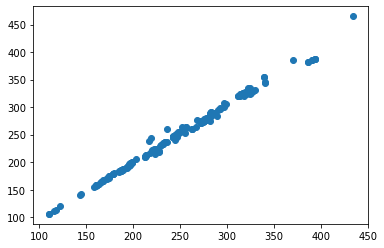

In [23]:
plt.plot(Pred, ValidY, 'o')
plt.show()